<a href="https://colab.research.google.com/github/masadeghi/dementia_clf_fmri/blob/main/experiments/analysis_scripts/fmri_dementia_multichannel_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [ ]:
import os
import gc
import time
from copy import deepcopy
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, balanced_accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

!pip install -qU tsai
from tsai.all import *

!pip install -qU focal_loss_torch
from focal_loss.focal_loss import FocalLoss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.3/272.3 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.9 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

In [ ]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Coding projects/resting_fmri_dementia/

/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia


In [ ]:
# Load with memmap
X = np.load('scaled_datasets_as_np_arrays/X_train_val.npy', mmap_mode = 'c')
y = np.load('scaled_datasets_as_np_arrays/y_train_val.npy', mmap_mode = 'c')
y = y - 1

## Restructure data

In [ ]:
X_reshaped = np.transpose(X, (1, 0, 2))

# Option 1: Build and train FCN model for each channel

## Custom classification metrics

In [ ]:
def balanced_accuracy(input, target):
  input, target = input.cpu(), target.cpu()
  input, target = flatten_check(input.argmax(axis = -1), target)
  output = balanced_accuracy_score(target, input)
  return output

## Train/val split

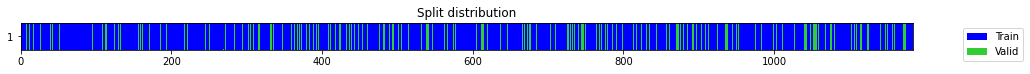

In [ ]:
 splits = get_splits(y, valid_size = .2, stratify = True, random_state = 42, shuffle = True)

## Train FCN model on each channel

In [ ]:
val_len = int(0.2 * X_reshaped.shape[1])
y_probas = np.empty((X_reshaped.shape[0], val_len, 4))
y_pred = np.empty((X_reshaped.shape[0], val_len))

Training run 10


Training run 20


Training run 30


Training run 40


Training run 50


Training run 60


Training run 70


Training run 80


Training run 90


Training run 100


Training run 110


Training run 120


Training run 130


Training run 140


Training run 150


Training run 160


Training run 170


Training run 180


Training run 190


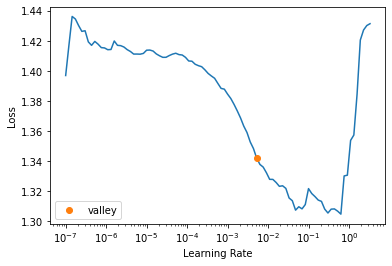

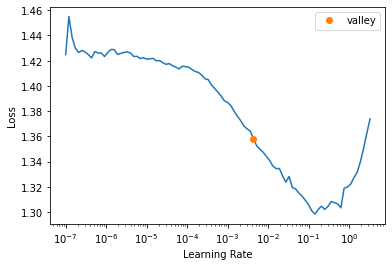

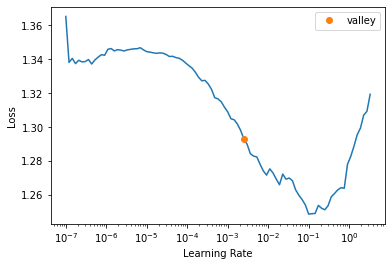

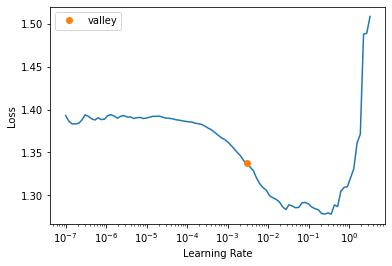

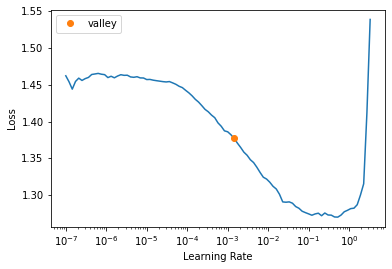

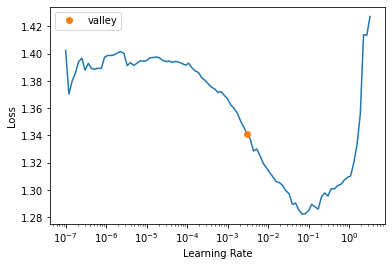

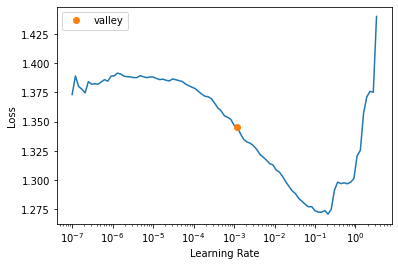

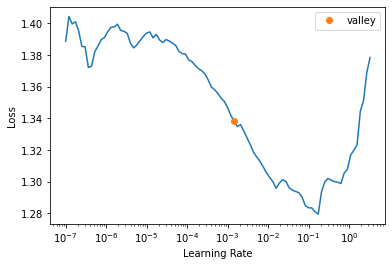

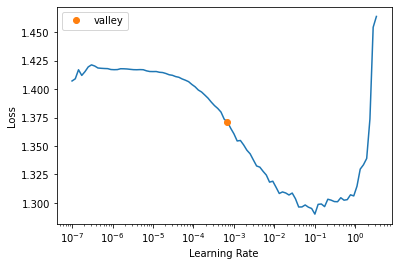

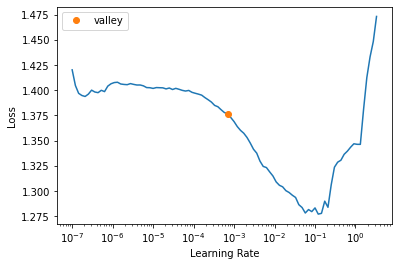

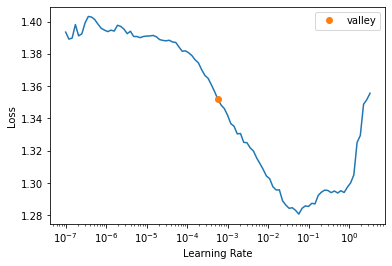

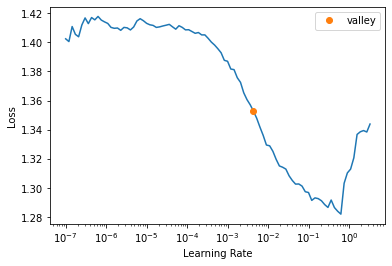

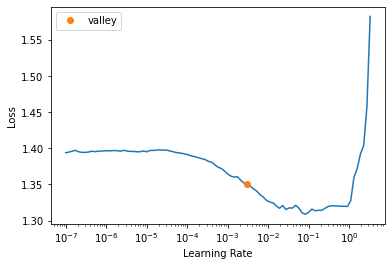

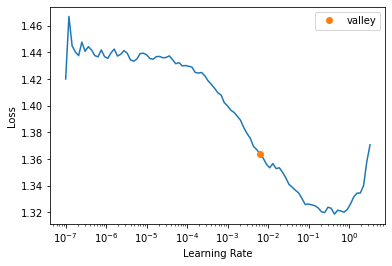

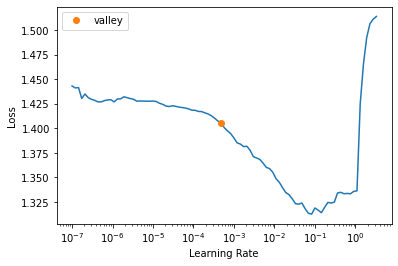

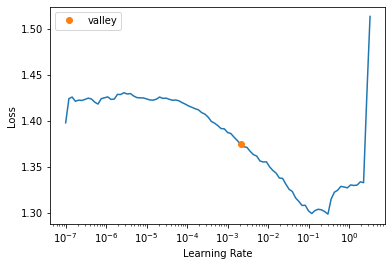

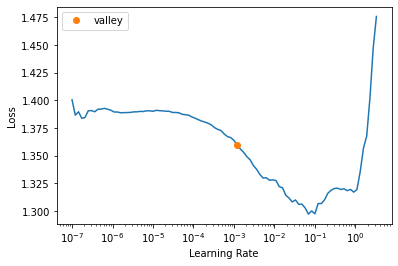

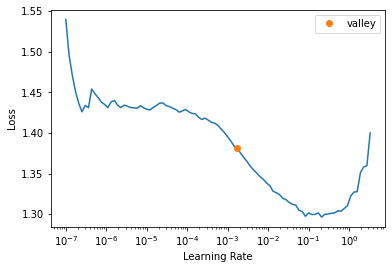

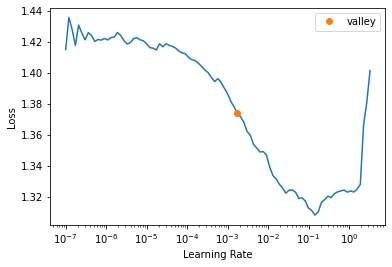

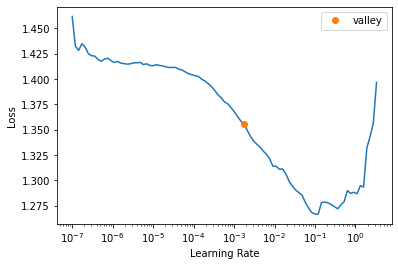

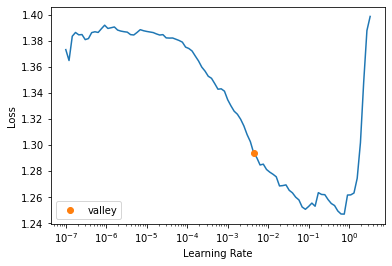

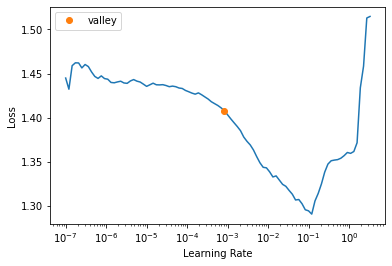

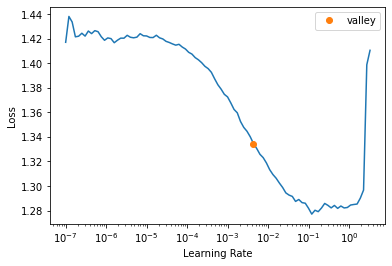

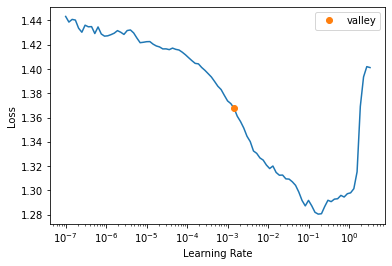

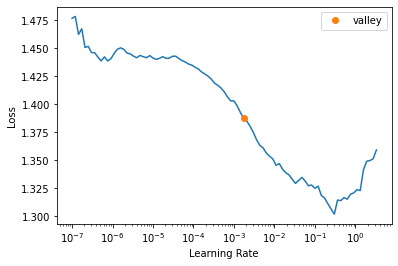

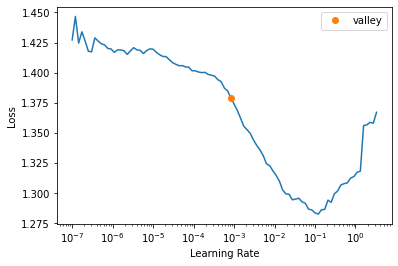

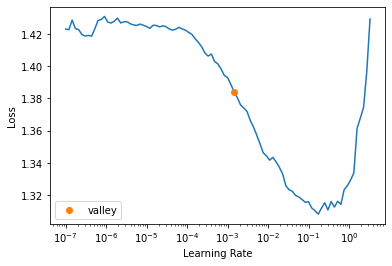

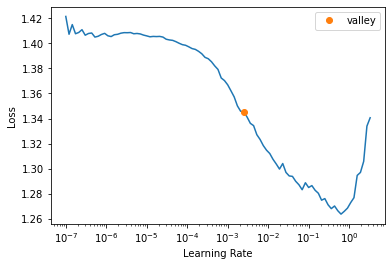

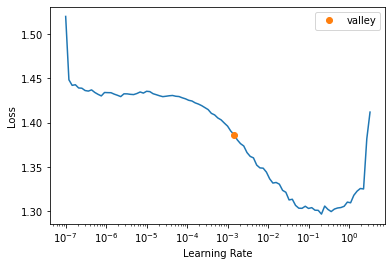

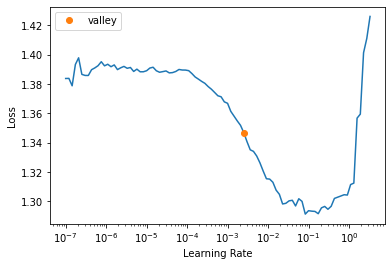

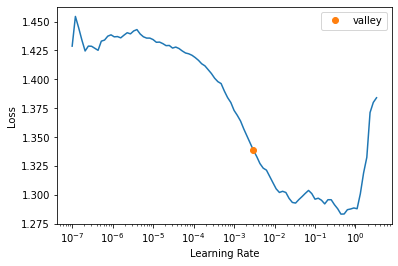

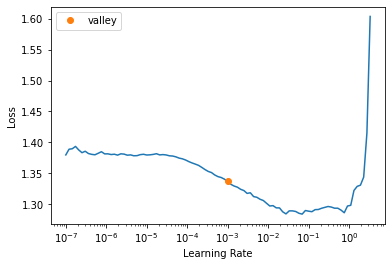

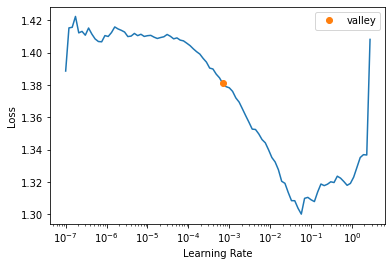

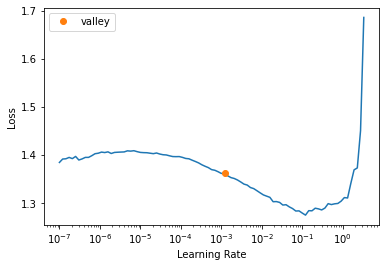

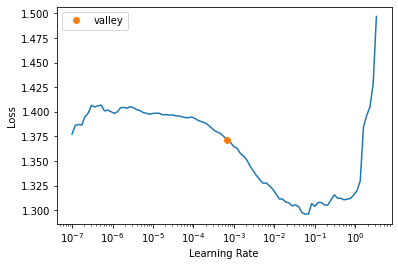

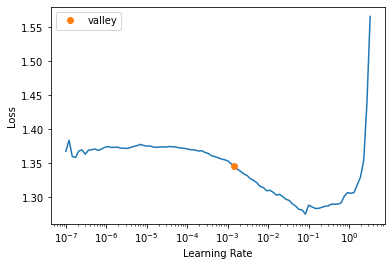

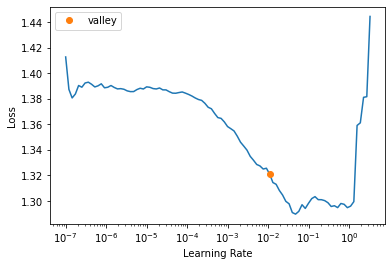

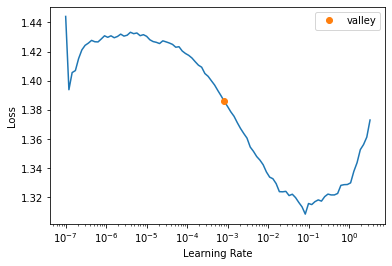

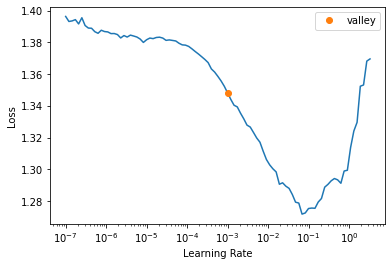

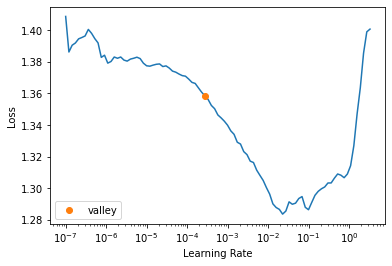

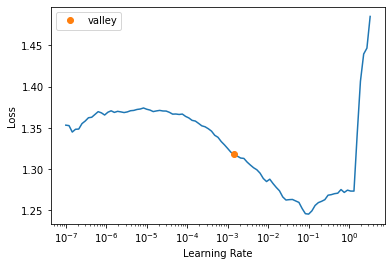

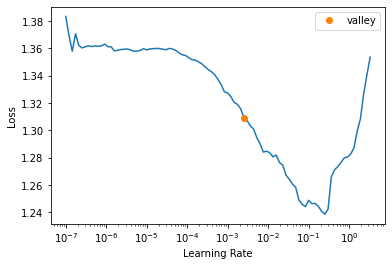

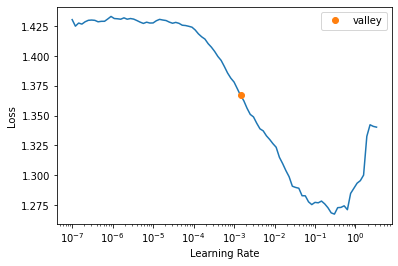

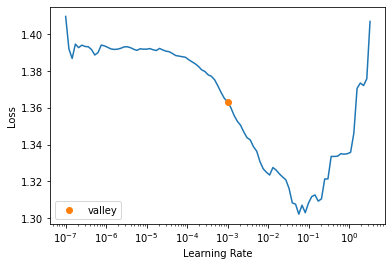

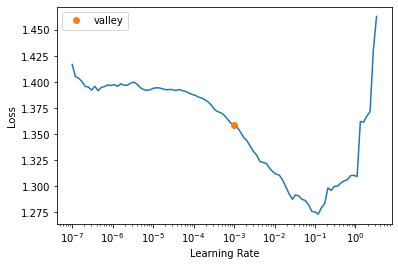

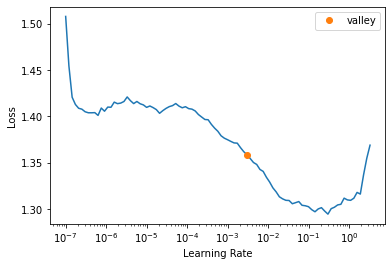

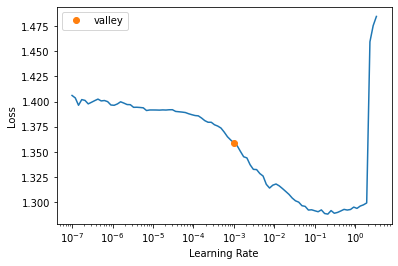

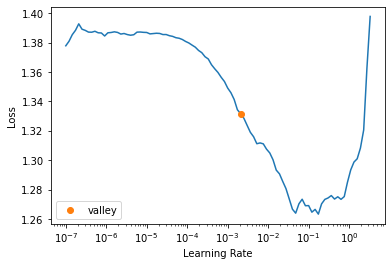

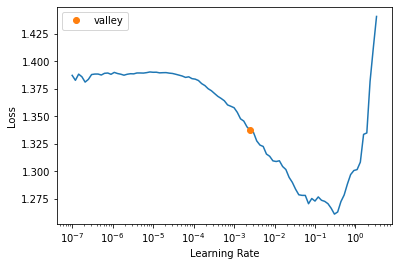

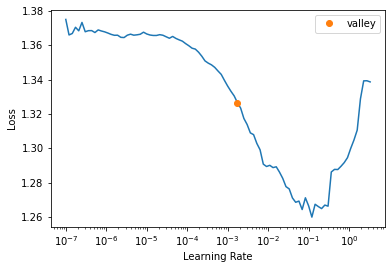

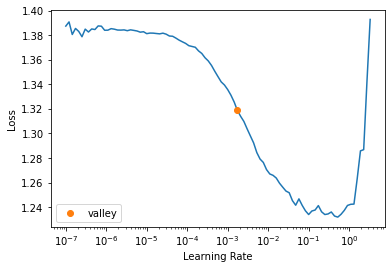

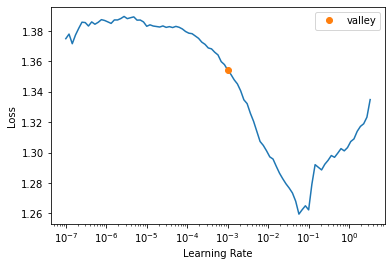

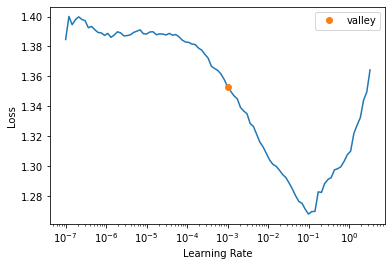

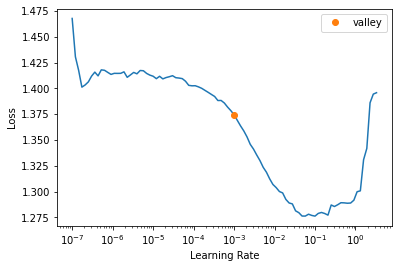

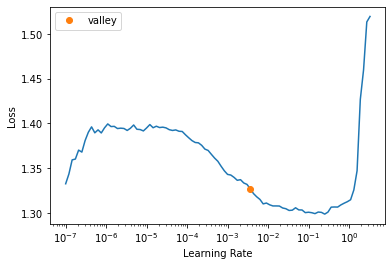

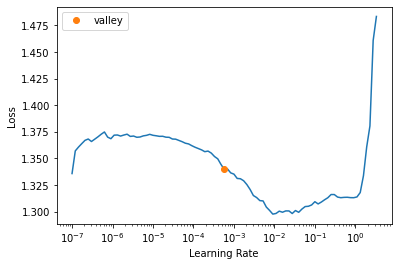

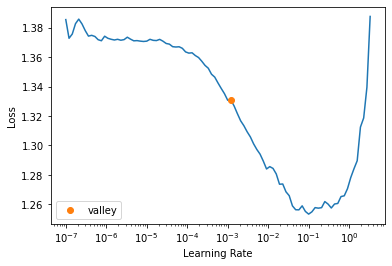

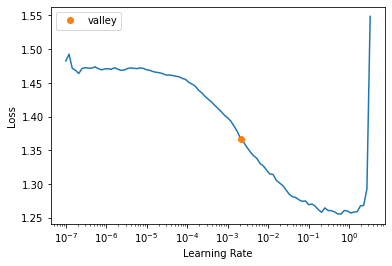

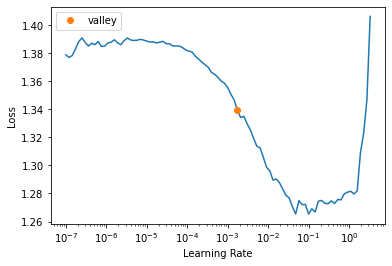

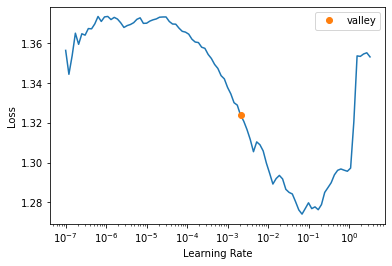

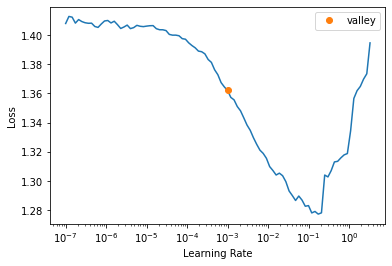

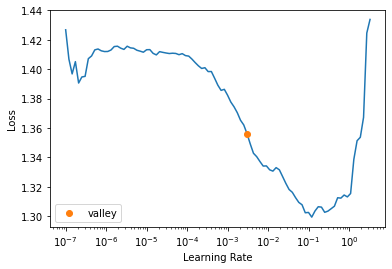

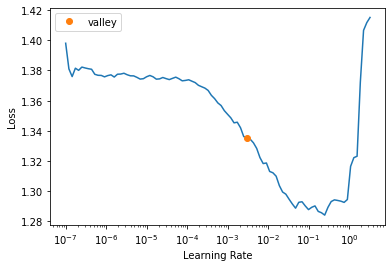

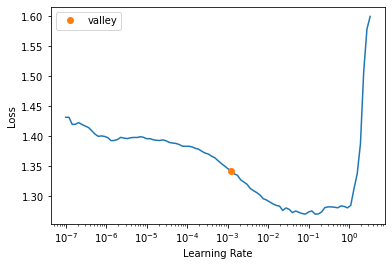

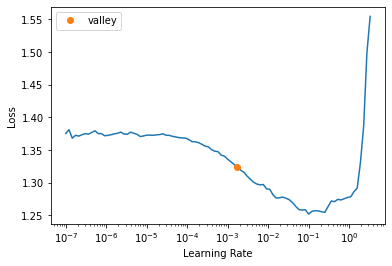

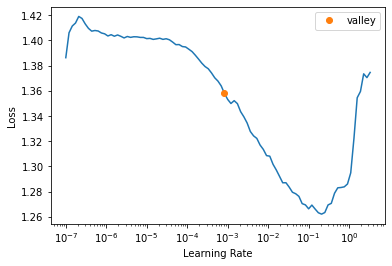

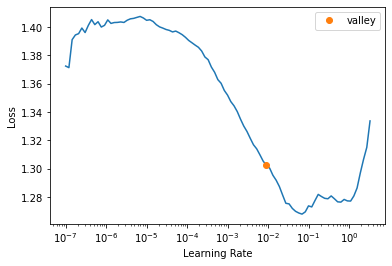

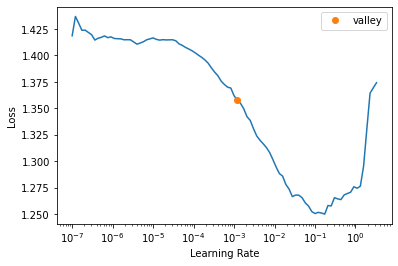

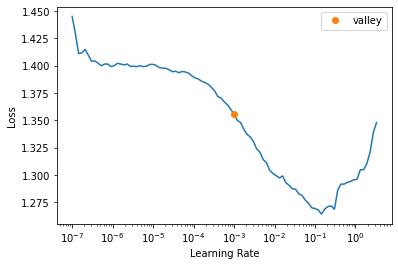

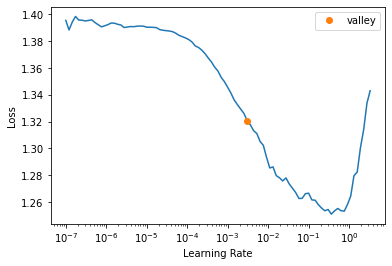

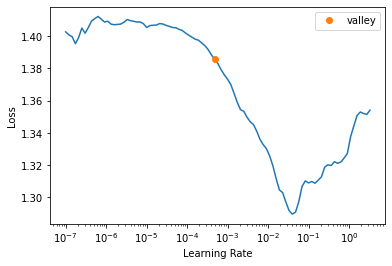

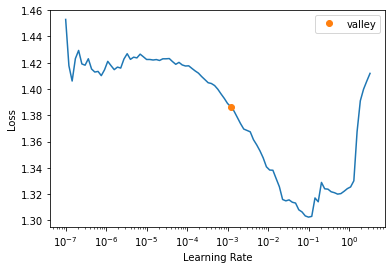

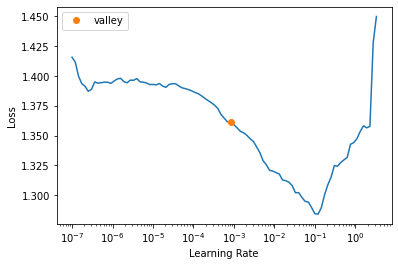

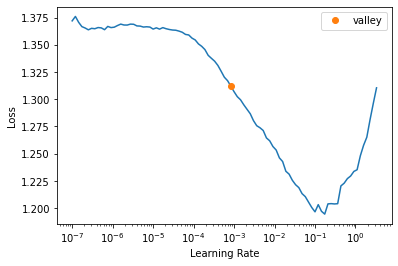

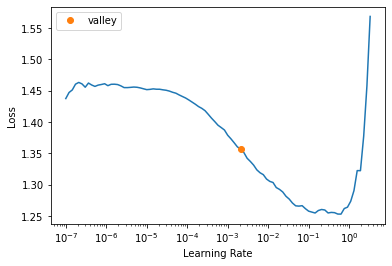

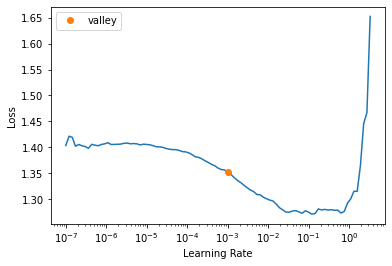

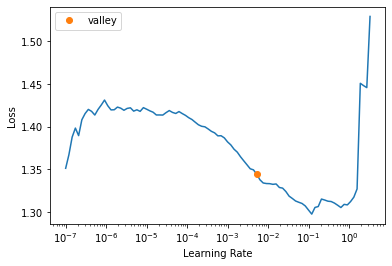

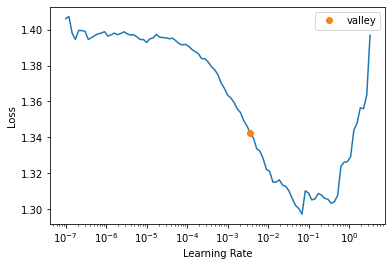

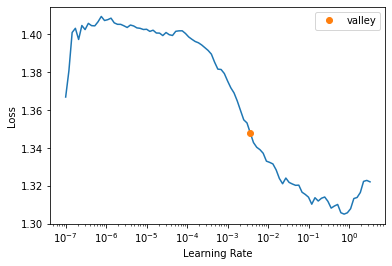

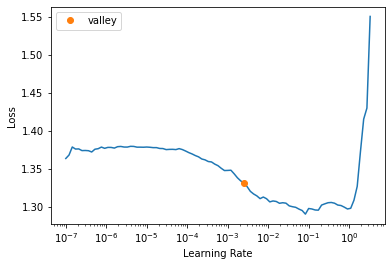

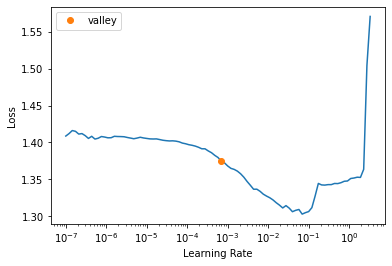

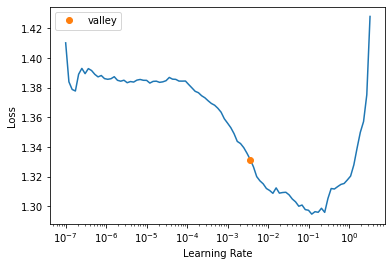

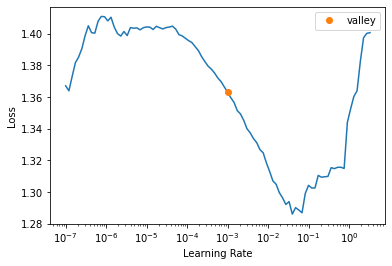

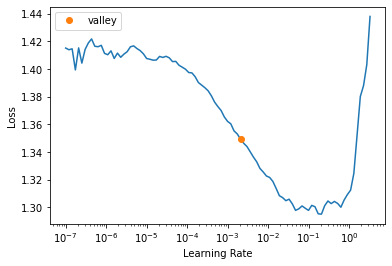

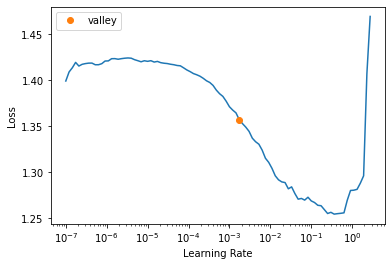

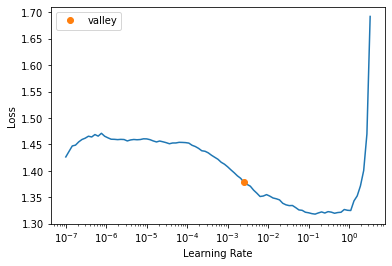

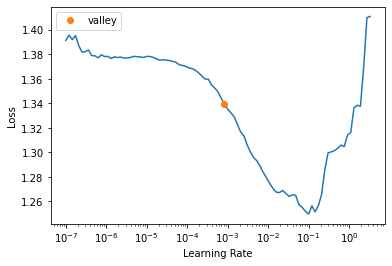

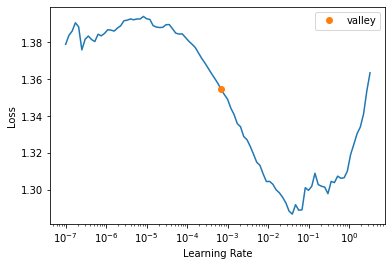

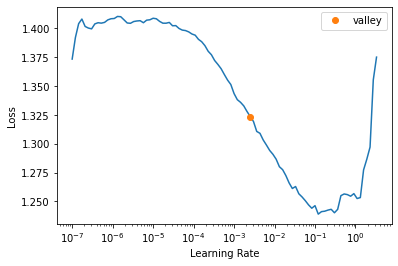

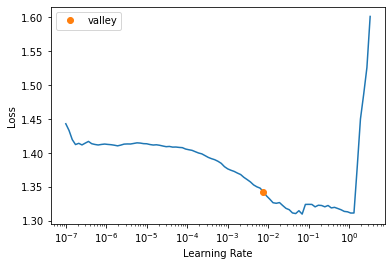

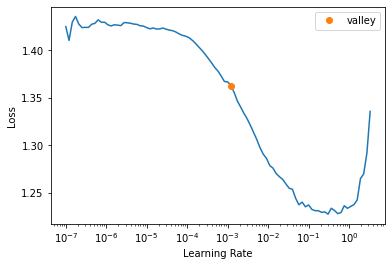

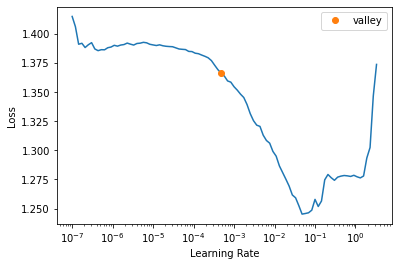

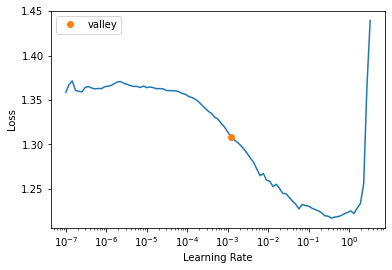

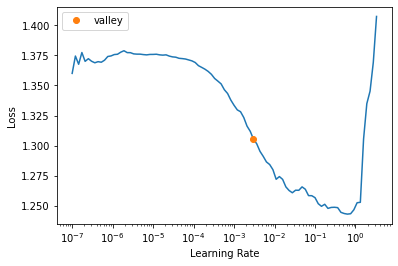

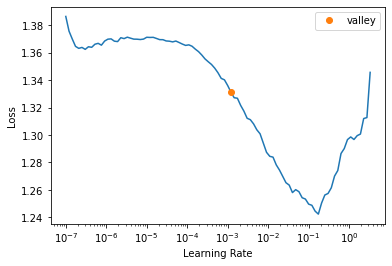

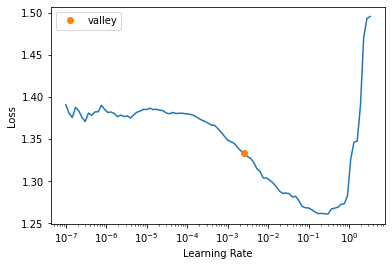

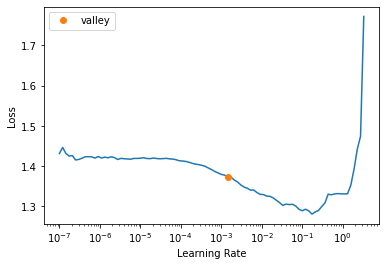

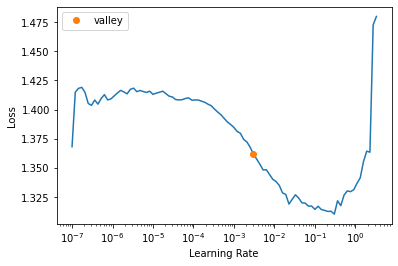

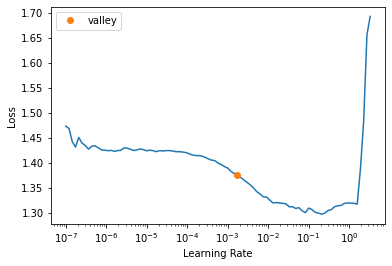

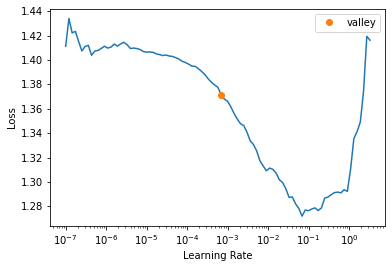

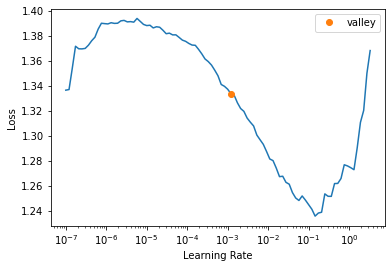

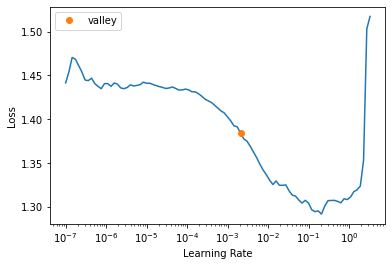

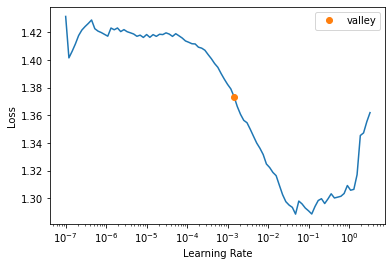

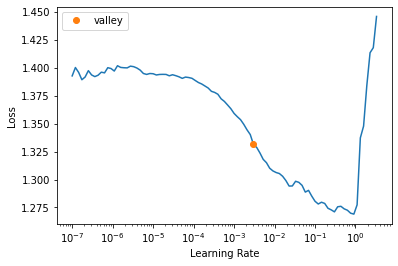

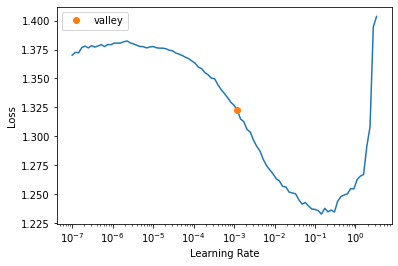

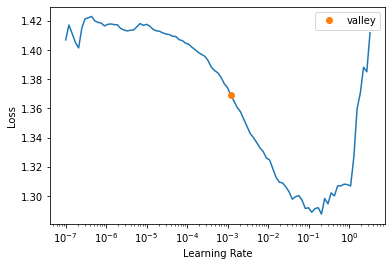

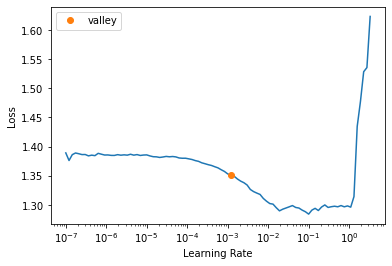

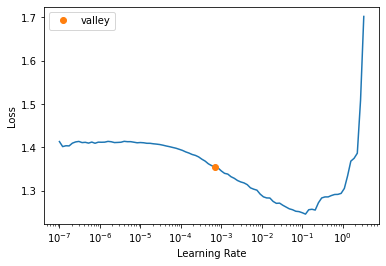

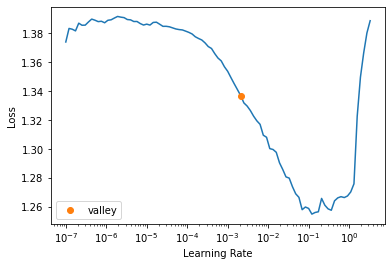

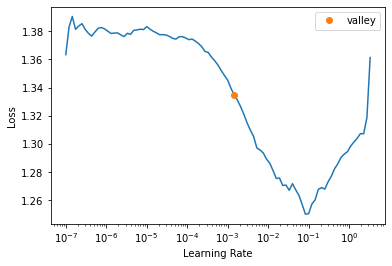

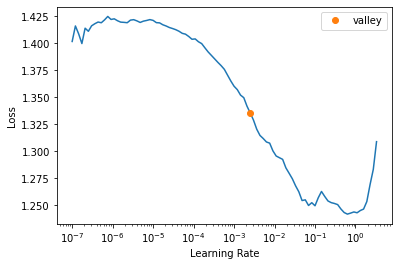

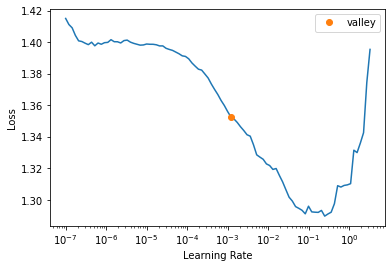

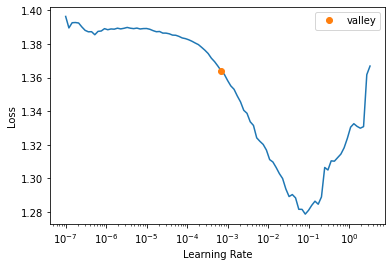

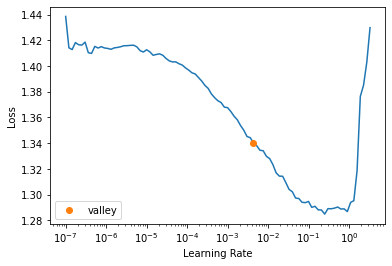

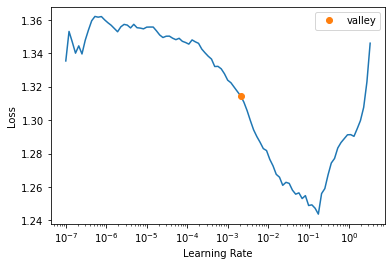

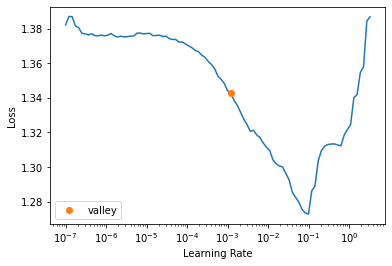

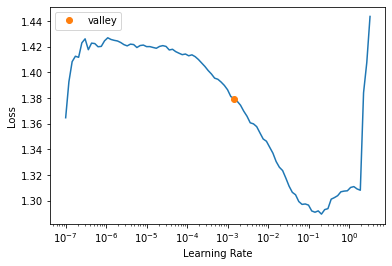

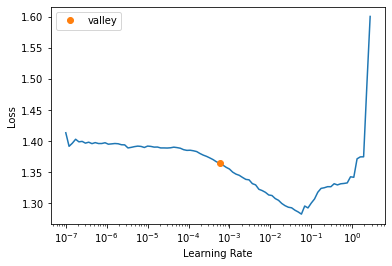

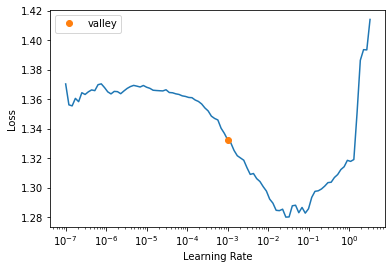

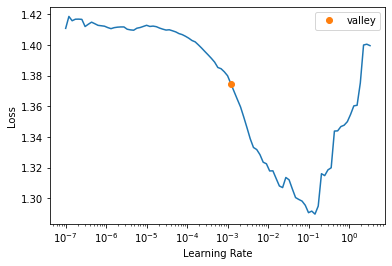

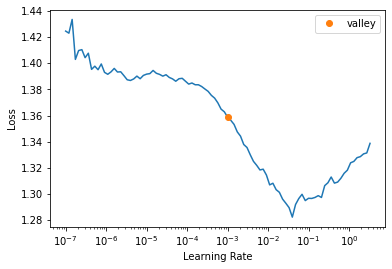

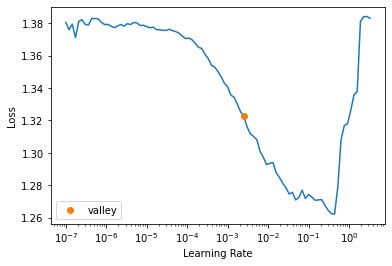

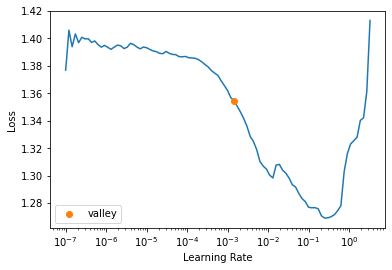

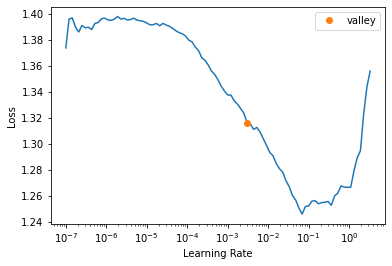

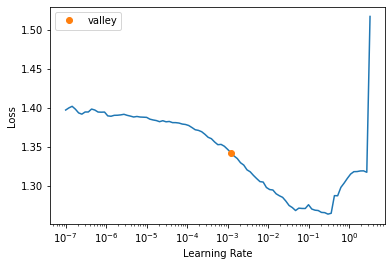

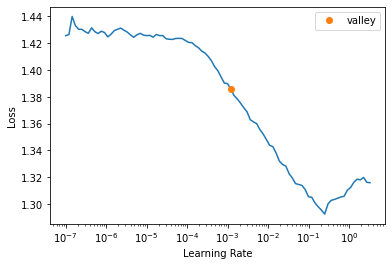

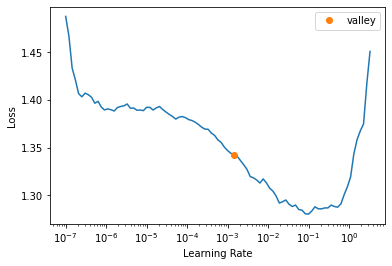

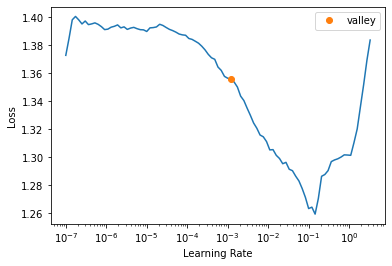

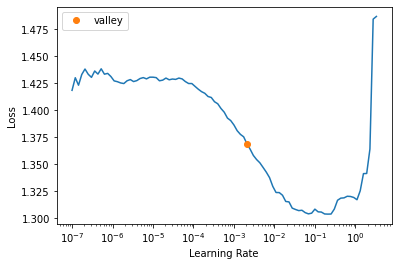

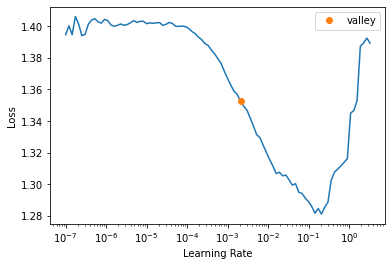

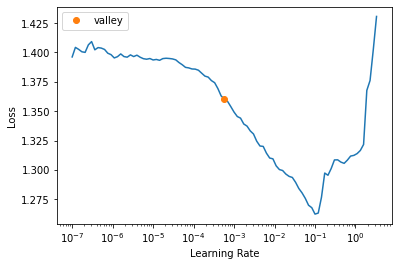

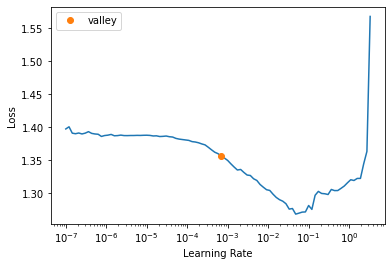

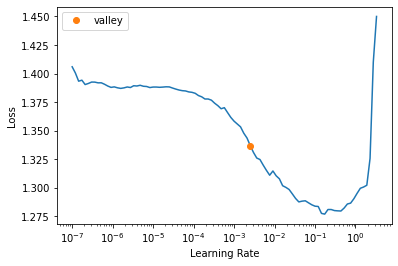

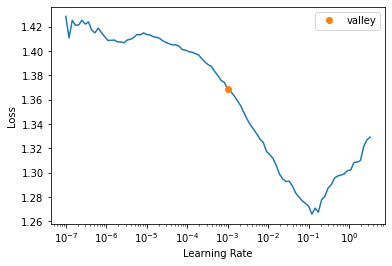

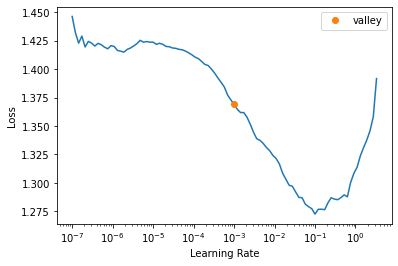

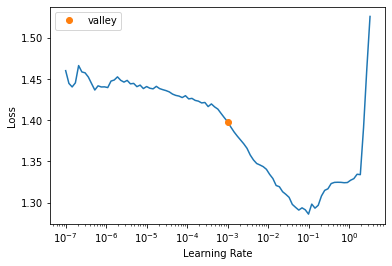

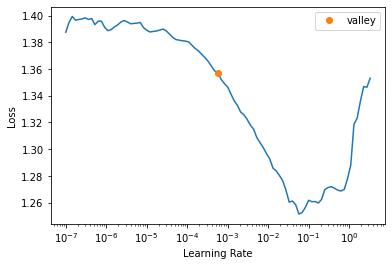

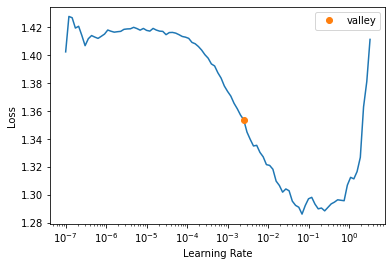

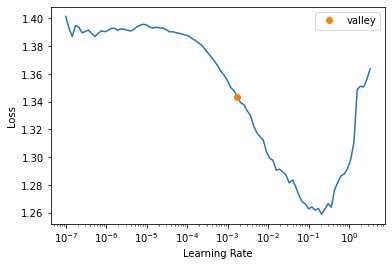

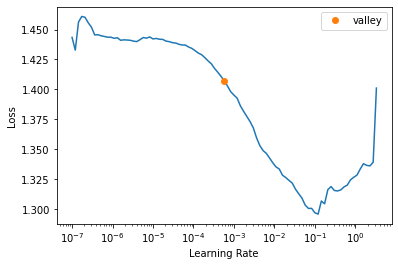

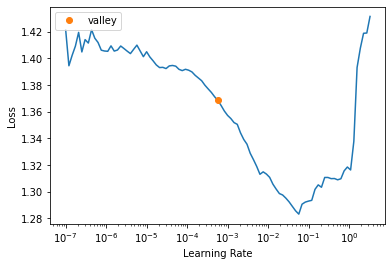

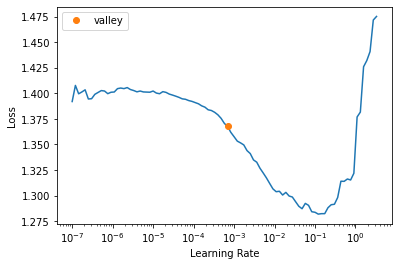

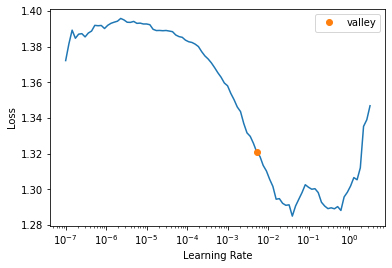

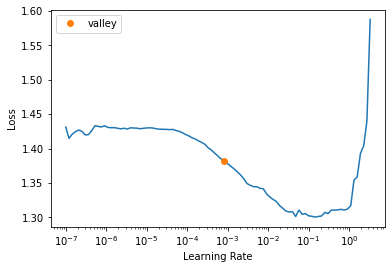

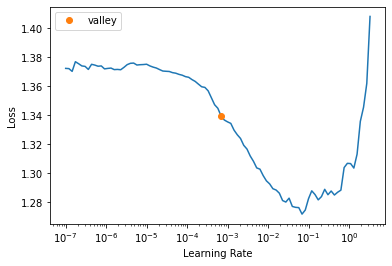

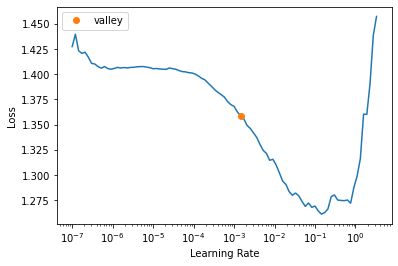

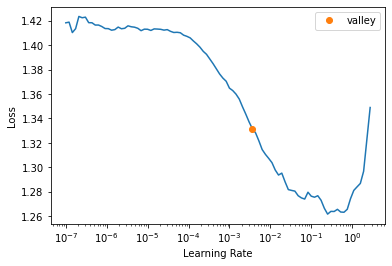

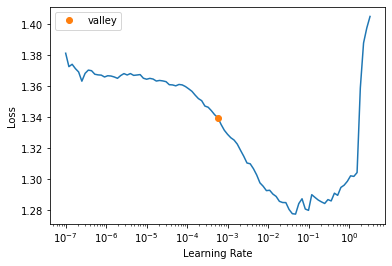

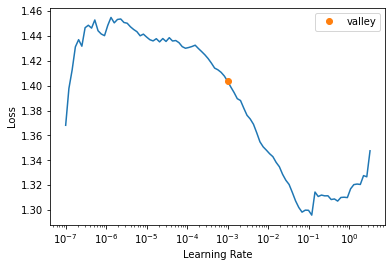

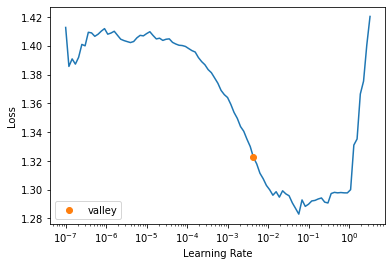

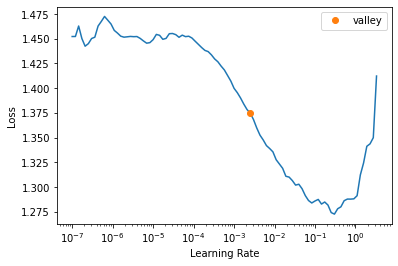

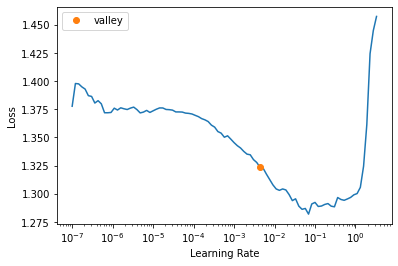

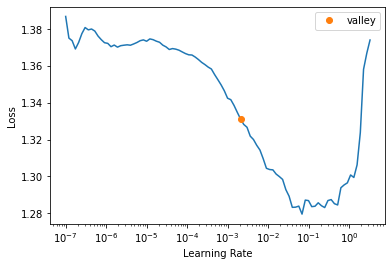

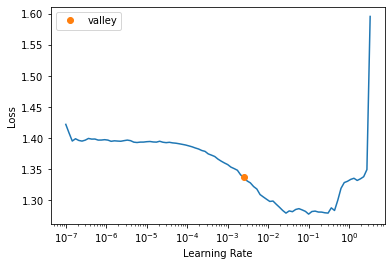

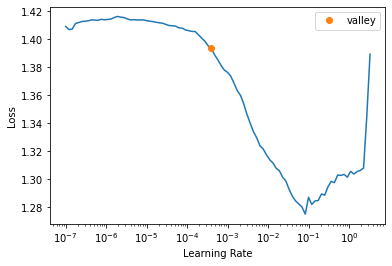

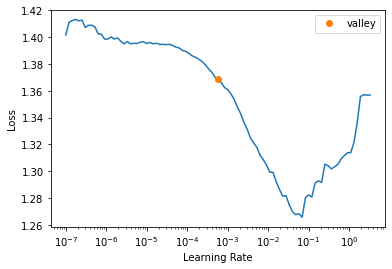

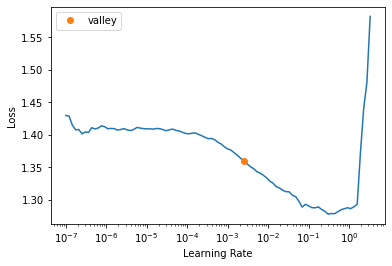

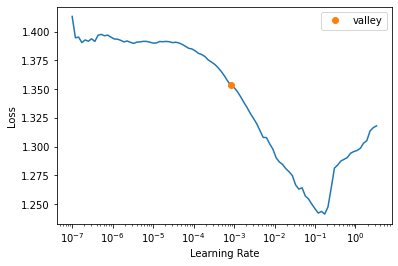

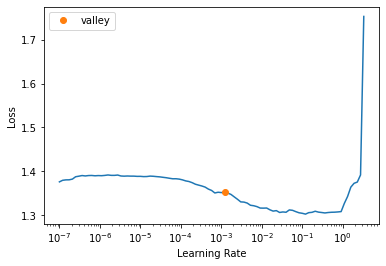

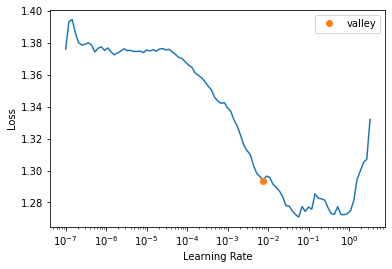

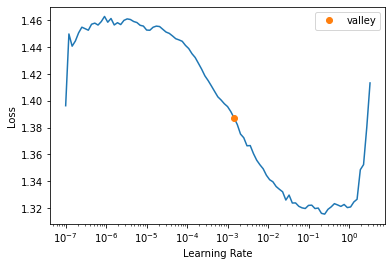

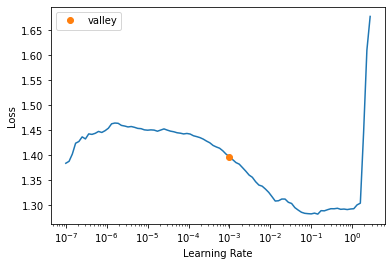

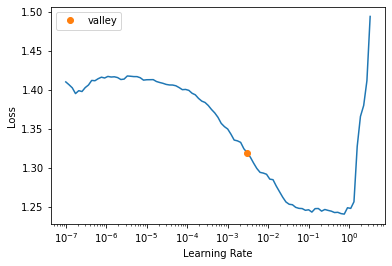

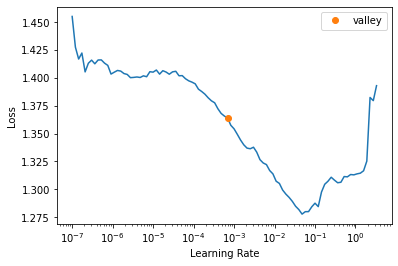

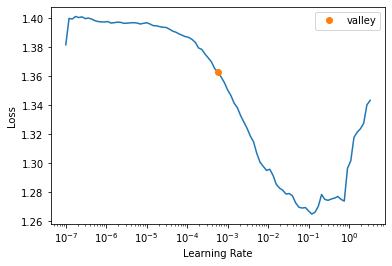

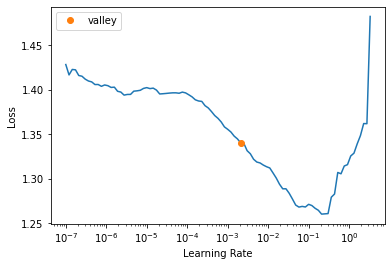

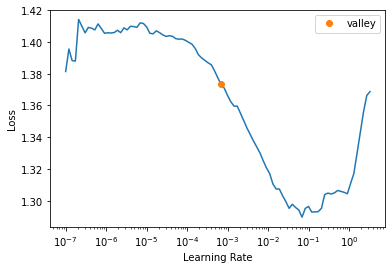

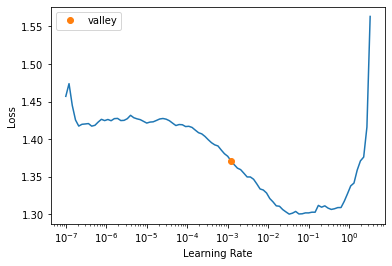

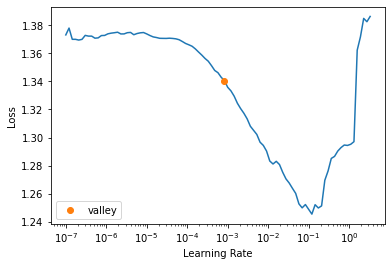

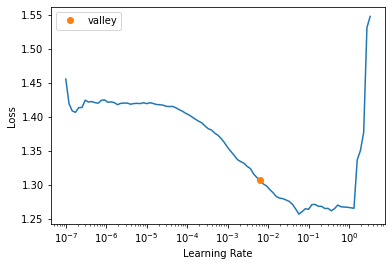

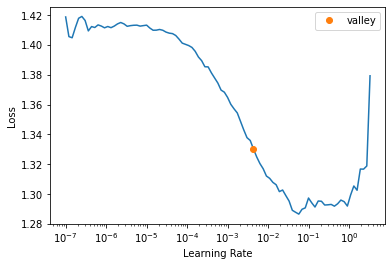

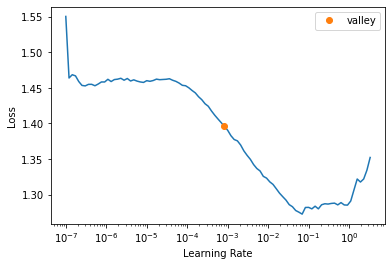

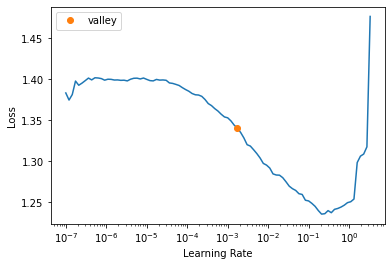

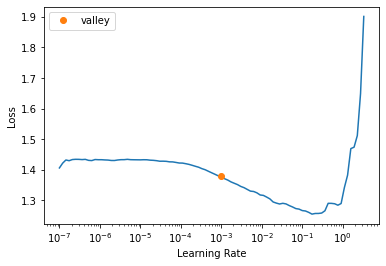

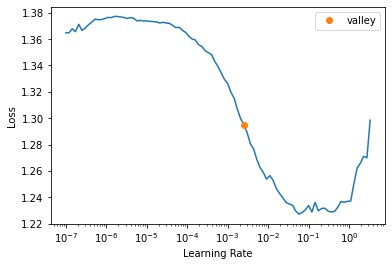

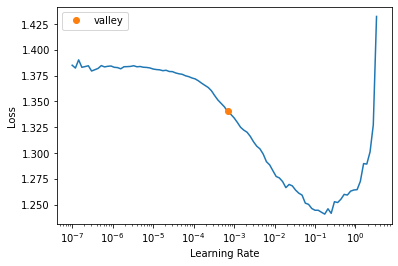

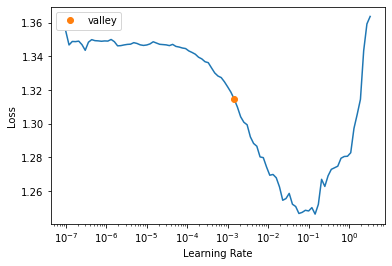

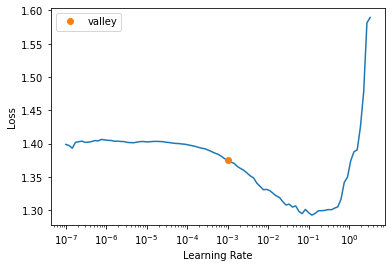

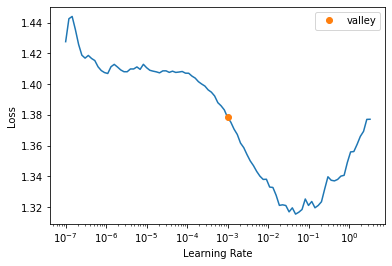

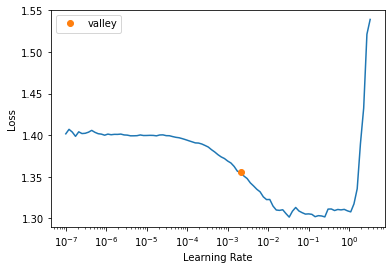

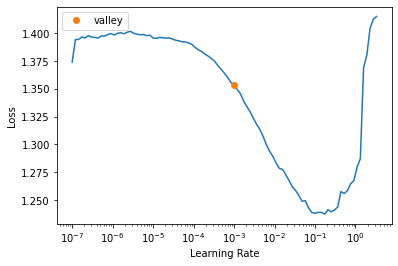

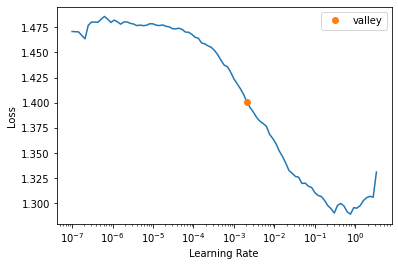

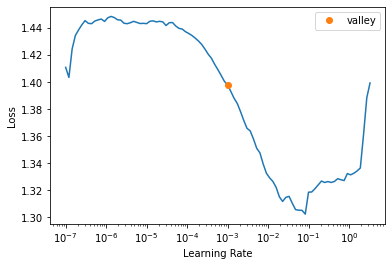

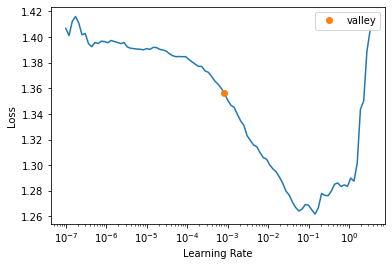

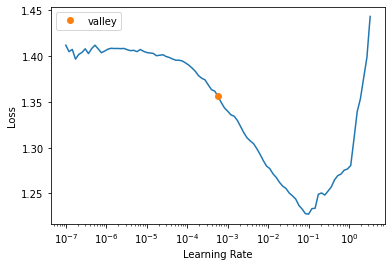

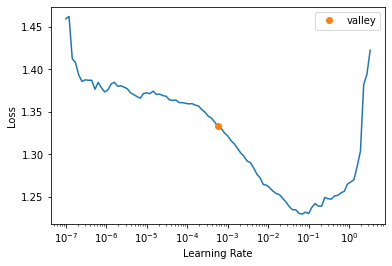

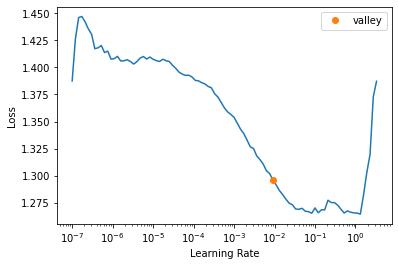

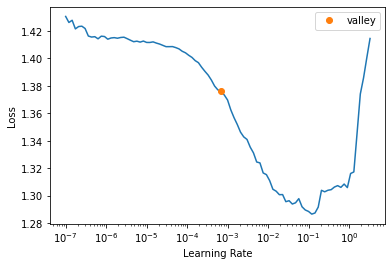

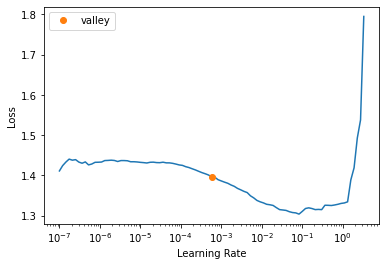

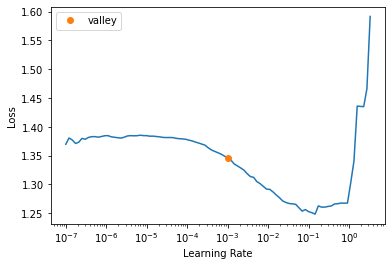

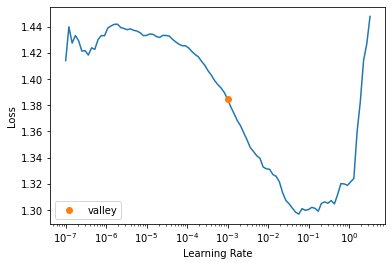

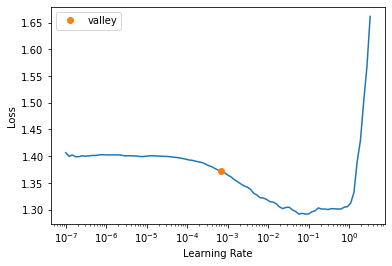

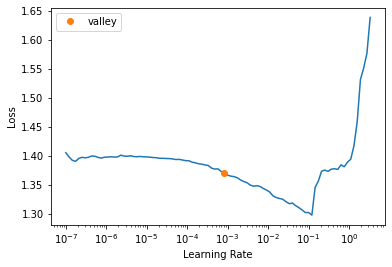

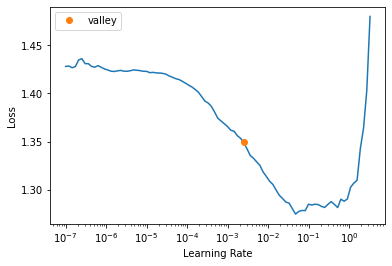

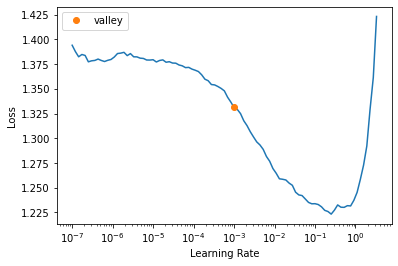

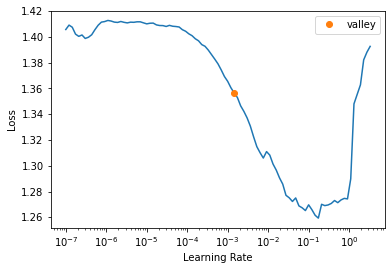

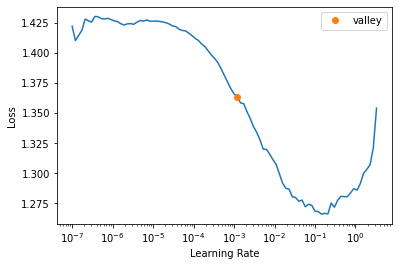

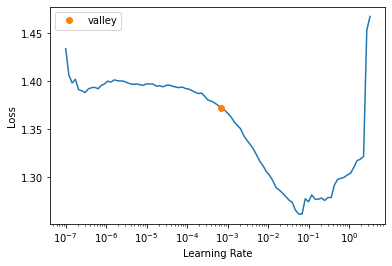

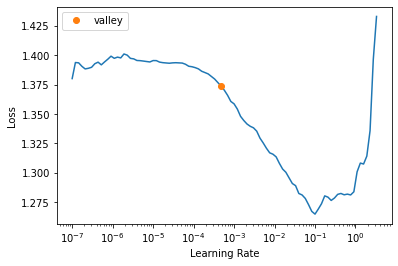

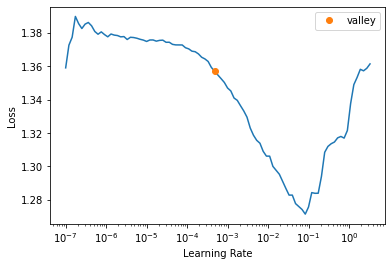

In [ ]:
for i in range(X_reshaped.shape[0]):

  X = X_reshaped[i, :, :]

  if i % 10 == 0 and i != 0:
    print(f'Training run {i}')

  tfms  = [None, [Categorize()]]
  dls_ts = get_ts_dls(X, y.astype(str), splits = splits, tfms = tfms)
  ts_model = FCN(dls_ts.vars, dls_ts.c)

  learn = Learner(dls_ts, ts_model, metrics = balanced_accuracy)
  learn.lr_find()
  learn.fit_one_cycle(20, lr_max = 1e-3)

  # export_path = os.path.join("model_weights", f"channel_{i}_fcn_20_epochs.pth")

  # learn.export(export_path)

  y_probas[i], _, y_pred[i] = learn.get_preds(dl = dls_ts.valid, with_decoded = True)

  del ts_model, learn, dls_ts
  gc.collect()

## Voting ensemble

In [ ]:
cumulative_probas = np.mean(y_probas, axis = 0)
cumulative_prediction = np.argmax(cumulative_probas, axis = -1)
cumulative_prediction = cumulative_prediction + 1

In [ ]:
y_val = np.load('scaled_datasets_as_np_arrays/y_val.npy', mmap_mode = 'c')

np.mean(cumulative_prediction == y_val), balanced_accuracy_score(y_val, cumulative_prediction)

(0.5822784810126582, 0.5337833452326864)

# Option 2 - Build InceptionTime model

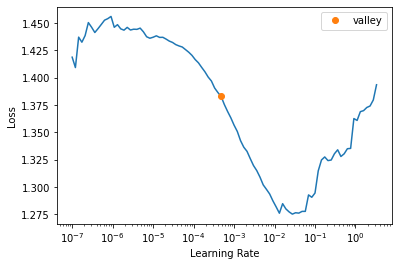

In [ ]:
tfms = [None, [Categorize()]]
dls_ts = get_ts_dls(X, y.astype(str), splits = splits, tfms = tfms)
ts_model = InceptionTime(dls_ts.vars, dls_ts.c, seq_len = 140)

learn = Learner(dls_ts, ts_model, metrics = balanced_accuracy)
learn.lr_find()
learn.fit_one_cycle(30, lr_max = 1e-3)

y_probas_it, _, y_pred_it = learn.get_preds(dl = dls_ts.valid, with_decoded = True)

# Optiion 3: Custom model - combination of per-channel FCN and overall InceptionTime

## Load data as tensors

In [ ]:
X_train = np.load('scaled_datasets_as_np_arrays/X_train.npy', mmap_mode = 'c')
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = np.load('scaled_datasets_as_np_arrays/y_train.npy', mmap_mode = 'c')
y_train = y_train - 1
y_train = torch.tensor(y_train, dtype = torch.float32)

X_val = np.load('scaled_datasets_as_np_arrays/X_val.npy', mmap_mode = 'c')
X_val = torch.tensor(X_val, dtype = torch.float32)
y_val = np.load('scaled_datasets_as_np_arrays/y_val.npy', mmap_mode = 'c')
y_val = y_val - 1
y_val = torch.tensor(y_val, dtype = torch.float32)

## Create dataloader

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, samples, labels):
    super().__init__()
    self.samples = samples
    self.labels = labels

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    sample = self.samples[idx, :, :]
    label = self.labels[idx]

    return sample, label

In [ ]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)

In [ ]:
train_batch_size = 32
val_batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = val_batch_size, shuffle = False)

In [ ]:
# Sample batch
for i, (samples, labels) in enumerate(train_loader):
    samples = samples.to(device)
    labels = labels.to(device)
    break

print("Batch shape:", samples.shape)
print("Sample tensor data type:", samples[0].type())
print("Label tensor data type:", labels[0].type())
print("Sample tensor:", samples[0])
print("Sample tensor device:", samples[0].device)
print('Batch labels:', labels)

Batch shape: torch.Size([32, 200, 140])
Sample tensor data type: torch.cuda.FloatTensor
Label tensor data type: torch.cuda.FloatTensor
Sample tensor: tensor([[ 0.0744, -0.0170, -0.2385,  ..., -0.1299,  0.6688, -0.2894],
        [-0.3550, -0.6436, -0.8516,  ...,  0.9182,  0.7578,  0.5531],
        [-0.2020, -0.5217, -0.7359,  ...,  0.4494,  0.6497,  0.3597],
        ...,
        [-0.0619, -0.1916, -0.4707,  ...,  0.2990,  0.4626,  0.2459],
        [ 0.4641, -0.1574, -0.1621,  ...,  0.2746,  0.8692,  0.1358],
        [-0.7969, -1.1750, -1.3999,  ...,  1.0347,  1.6624,  1.3986]],
       device='cuda:0')
Sample tensor device: cuda:0
Batch labels: tensor([2., 3., 0., 3., 2., 0., 2., 1., 3., 1., 2., 3., 1., 0., 0., 2., 1., 0.,
        2., 1., 1., 0., 1., 2., 0., 2., 2., 0., 1., 2., 1., 1.],
       device='cuda:0')


## Custom FCN/InceptionTime combination

### Modified FCN

In [ ]:
class custom_FCN(nn.Module):
    def __init__(self, c_in, layers=[128, 256, 128], kss=[7, 5, 3]):

        super().__init__()

        assert len(layers) == len(kss)
        self.convblock1 = ConvBlock(c_in, layers[0], kss[0])
        self.convblock2 = ConvBlock(layers[0], layers[1], kss[1])
        self.convblock3 = ConvBlock(layers[1], layers[2], kss[2])
        self.gap = GAP1d(1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.gap(x)
        return x

### Custom FCN/InceptionTime

In [ ]:
class custom_Model(nn.Module):

  def __init__(self,
               num_channels,
               FCN_c_in = 1, FCN_layers = [128, 256, 128], FCN_kss = [7, 5, 3],
               IT_c_out = 4, IT_seq_len = None, IT_nf =  32, IT_nb_filters = None, IT_ks = 30):

    super().__init__()

    assert len(FCN_layers) == len(FCN_kss)
    self.num_channels = num_channels

    FCN_list = []
    for i in range(num_channels):
      FCN_list.append(custom_FCN(FCN_c_in, FCN_layers, FCN_kss).to(device))

    self.last_layer = FCN_layers[-1]

    self.FCN_list = FCN_list
    self.IT_model = InceptionTime(c_in = num_channels, c_out = IT_c_out, seq_len = IT_seq_len,
                                  nf = IT_nf, nb_filters = IT_nb_filters, ks = IT_ks).to(device)


  def forward(self, x):
    assert len(x.shape) == 3

    FCN_outputs = torch.empty((x.shape[0], x.shape[1], self.last_layer)).to(device)

    for i in range(self.num_channels):
      x_run = x[:, i, :]
      x_run = torch.unsqueeze(x_run, axis = 1)
      vec_rep = self.FCN_list[i](x_run)
      FCN_outputs[:, i, :] = vec_rep

    final_pred = self.IT_model(FCN_outputs)

    final_pred = nn.Softmax(dim = -1)(final_pred)

    return final_pred

## Instantiate model

In [ ]:
_, counts = np.unique(y, return_counts = True)
class_weights = (counts.max()/counts)
class_weights = torch.FloatTensor(class_weights).to(device)

In [ ]:
torch.manual_seed(42)
custom_model = custom_Model(num_channels = 200,
                            FCN_c_in = 1, FCN_layers = [128, 256, 128], FCN_kss = [7, 5, 3],
                            IT_c_out = 4)

custom_model = custom_model.to(device)

criterion = FocalLoss(gamma = 2, weights = class_weights)
optimizer = torch.optim.Adam(custom_model.parameters())

In [ ]:
sum(p.numel() for p in custom_model.parameters())

395268

In [ ]:
next(custom_model.parameters()).device

device(type='cuda', index=0)

## Training loop

In [ ]:
train_losses = []
train_accuracies = []
train_f1s = []
train_aucs = []

val_losses = []
val_accuracies = []
val_f1s = []
val_aucs = []

def train_model(model, criterion, optimizer, num_epochs = 5):

  torch.manual_seed(42)

  since = time.time()

  best_model_wts = deepcopy(model.state_dict())
  best_f1 = 0.0

  if device == "cuda":
    torch.backends.cudnn.benchmark = True

  scaler = torch.cuda.amp.GradScaler()

  # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.1, epochs = num_epochs,
  #                                                 steps_per_epoch = len(train_loader))

  for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 10)

    for phase in ['train', 'validation']:
      if phase == 'train':
          model.train()
          dataset = train_dataset
          dataloader = train_loader
      else:
          model.eval()
          dataset = val_dataset
          dataloader = val_loader

      running_loss = 0.0
      running_outputs = torch.empty(0).to(device)
      running_preds = torch.empty(0).to(device)
      running_labels = torch.empty(0).to(device)

      for inputs, labels in dataloader:
          inputs = inputs.to(device)
          labels = labels.long().to(device)

          if phase == 'train':
            with torch.cuda.amp.autocast():
              outputs = model(inputs)
              loss = criterion(outputs, labels)
          else:
            with torch.no_grad():
              with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

          if phase == 'train':
              optimizer.zero_grad()
              # loss.backward()
              # optimizer.step()
              scaler.scale(loss).backward()
              scaler.step(optimizer)
              # scheduler.step()
              scaler.update()

          preds = torch.argmax(outputs, axis = -1).to(device)
          running_preds = torch.cat([running_preds, preds])

          running_loss += loss.item() * inputs.size(0)
          running_outputs = torch.cat([running_outputs, outputs])
          running_labels = torch.cat([running_labels, labels])

      if torch.cuda.is_available():
        running_labels = running_labels.detach().cpu().numpy()
        running_preds = running_preds.detach().cpu().numpy()
        if phase == "train":
          running_outputs = running_outputs.detach().cpu().numpy()
        else:
          running_outputs = running_outputs.cpu().numpy()

      epoch_loss = running_loss / len(dataset)
      epoch_accuracy = balanced_accuracy_score(running_labels, running_preds)
      epoch_f1 = f1_score(running_labels, running_preds, average = 'weighted')
      epoch_auc = roc_auc_score(running_labels, running_outputs, multi_class = "ovr", average = "weighted")

      print('{} loss: {:.4f}, accuracy: {:.4f}, f1: {:.4f}, auc: {:.4f}'.format(phase, epoch_loss, epoch_accuracy, epoch_f1, epoch_auc))

      if phase == 'train':
          train_losses.append(epoch_loss)
          train_accuracies.append(epoch_accuracy)
          train_f1s.append(epoch_f1)
          train_aucs.append(epoch_auc)
      else:
          val_losses.append(epoch_loss)
          val_accuracies.append(epoch_accuracy)
          val_f1s.append(epoch_f1)
          val_aucs.append(epoch_auc)

      if phase == 'validation' and epoch_f1 > best_f1:
          best_f1 = epoch_f1
          best_model_wts = deepcopy(model.state_dict())

      del epoch_loss, epoch_accuracy, epoch_f1, epoch_auc, running_loss, running_preds, running_outputs, running_labels
      torch.cuda.empty_cache()
      gc.collect()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val F1 score: {best_f1:4f}')

  return model

In [ ]:
epochs = 50

model_trained = train_model(custom_model, criterion, optimizer, num_epochs = epochs)

Epoch 1/50
----------
train loss: 0.6173, accuracy: 0.4674, f1: 0.4771, auc: 0.7370
validation loss: 0.6132, accuracy: 0.4669, f1: 0.4438, auc: 0.7336
Epoch 2/50
----------
train loss: 0.4538, accuracy: 0.5535, f1: 0.5480, auc: 0.8078
validation loss: 0.5309, accuracy: 0.4780, f1: 0.4856, auc: 0.7599
Epoch 3/50
----------
train loss: 0.4251, accuracy: 0.5769, f1: 0.5571, auc: 0.8175
validation loss: 0.9414, accuracy: 0.4006, f1: 0.3620, auc: 0.7394
Epoch 4/50
----------
train loss: 0.3618, accuracy: 0.6275, f1: 0.6037, auc: 0.8487
validation loss: 0.9735, accuracy: 0.3315, f1: 0.3141, auc: 0.6959
Epoch 5/50
----------


KeyboardInterrupt: ignored